In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import Models.Neural_Networks.util as util

In [24]:
df = pd.read_csv('Datasets/Lynx_Hare/data.csv', usecols=['DATE', 'HARE', 'LYNX'])

# Create lagged features for one-step ahead prediction
df['HARE_lag1'] = df['HARE'].shift(1)
df['LYNX_lag1'] = df['LYNX'].shift(1)
dataset_name = 'Lynx and Hare'

df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['HARE_lag1', 'LYNX_lag1']].values  # previous time step's data as input
y = df[['HARE', 'LYNX']].values  
species = ['HARE', 'LYNX']
print(df)

    DATE   HARE   LYNX  HARE_lag1  LYNX_lag1
1   1846  19.60  45.15      19.58      30.09
2   1847  19.61  49.15      19.60      45.15
3   1848  11.99  39.52      19.61      49.15
4   1849  28.04  21.23      11.99      39.52
5   1850  58.00   8.42      28.04      21.23
..   ...    ...    ...        ...        ...
86  1931  19.52   8.31       4.23       6.98
87  1932  82.11  16.01      19.52       8.31
88  1933  89.76  24.82      82.11      16.01
89  1934  81.66  29.70      89.76      24.82
90  1935  15.76  35.40      81.66      29.70

[90 rows x 5 columns]


In [25]:
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [26]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

y_train = y_train.reshape((y_train.shape[0], 1, y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], 1, y_test.shape[1]))

In [27]:
model = Sequential([
    LSTM(10, activation='relu', input_shape=(1, x_train.shape[2])),
    Dense(2)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/Users/ethankaji/Development/ML-on-Graphs-Project/311venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


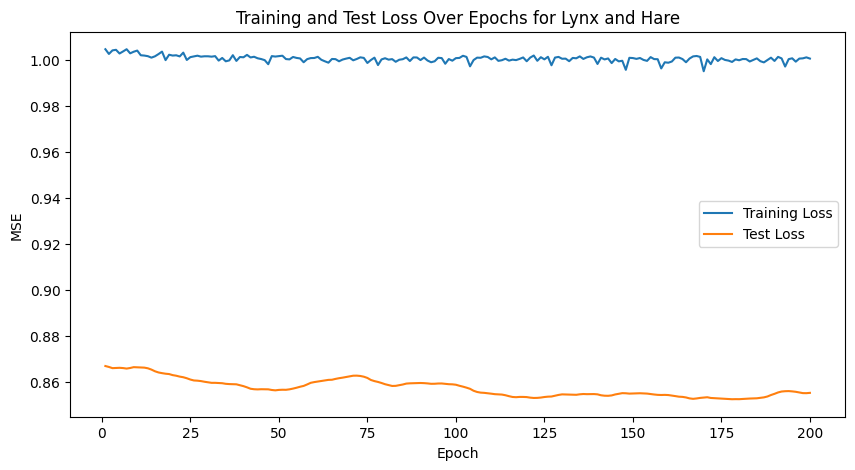

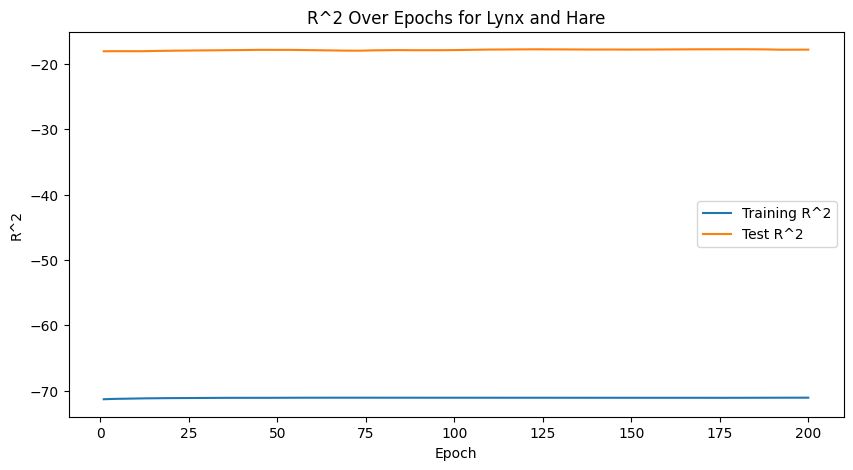

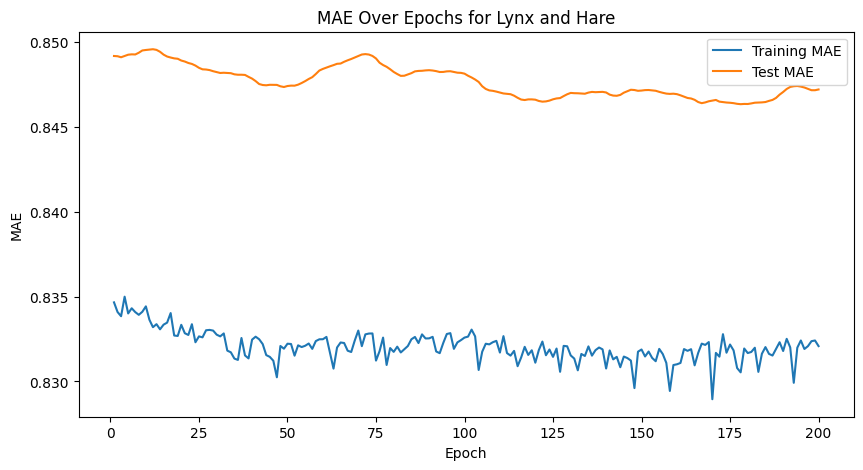

Final Test MSE: 0.8553005456924438
Final Test MAE: 0.8472123742103577
Final Test R2: -17.835665366618223


In [28]:
epochs = 200
train_losses = []
test_losses = []

train_r2 = []
test_r2 = []

train_mae = []
test_mae = []

for epoch in range(epochs):
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=32, verbose=0)
        
    # Access losses directly from history object
    train_mse = history.history['loss'][-1]
    test_mse = history.history['val_loss'][-1]
    train_mae_score = history.history['mean_absolute_error'][-1]
    test_mae_score = history.history['val_mean_absolute_error'][-1]

    y_train_pred = model.predict(x_train, verbose=0)
    y_test_pred = model.predict(x_test, verbose=0)
    train_r2_score = util.r_squared(y_train, y_train_pred)
    test_r2_score = util.r_squared(y_test, y_test_pred)
    
    train_losses.append(train_mse)
    test_losses.append(test_mse)
    train_mae.append(train_mae_score)
    test_mae.append(test_mae_score)
    train_r2.append(train_r2_score)
    test_r2.append(test_r2_score)

# Plotting training and testing loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(f'Training and Test Loss Over Epochs for {dataset_name}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_r2, label='Training R^2')
plt.plot(range(1, epochs+1), test_r2, label='Test R^2')
plt.title(f'R^2 Over Epochs for {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_mae, label='Training MAE')
plt.plot(range(1, epochs+1), test_mae, label='Test MAE')
plt.title(f'MAE Over Epochs for {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Final evaluation
final_mse_test = test_losses[-1]
final_mae_test = test_mae[-1]
final_r2_test = test_r2[-1]
print(f'Final Test MSE: {final_mse_test}')
print(f'Final Test MAE: {final_mae_test}')
print(f'Final Test R2: {final_r2_test}')

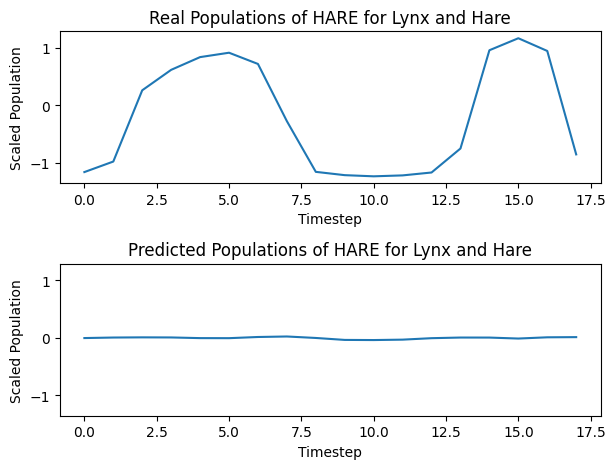

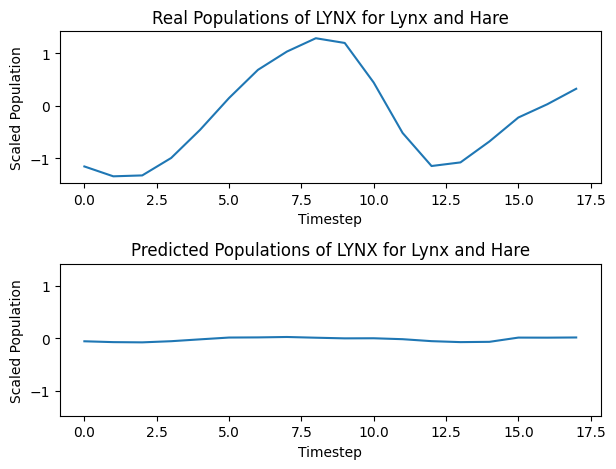

In [29]:
for expected, predicted, s  in zip(y_test.T, y_test_pred.T, species):
    _, (real, pred) = plt.subplots(2, sharey = True)
    pred.plot(range(len(predicted)), predicted.squeeze())
    pred.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    pred.set_xlabel('Timestep')
    pred.set_ylabel('Scaled Population')
    real.plot(range(len(predicted)), expected.squeeze())
    real.title.set_text(f'Real Populations of {s} for {dataset_name}')
    real.set_xlabel('Timestep')
    real.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()



In [30]:
df = pd.read_csv('Datasets/study_373/top_5_373_time.csv', usecols=['46670', '46982', '46504', '46571', '46888'])
"""
46670  [Nyctereutes procyonoides]     Common Raccoon Dog      -> Rodents, Japanese Hare
46982  [Sus scrofa]				      Wild Boar               -> Rodents, Japanese Hare
46504  [Lepus brachyurus]			  Japanese Hare
46571  [Meles anakuma]			      Japanese Badger         -> Rodents
46888  [Rodentia]
"""


for col in ['46670', '46982', '46504', '46571', '46888']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)
dataset_name = 'BioTIME Study 373'

# Define features (x) and targets (y)
x = df[['46670_lag1', '46982_lag1', '46504_lag1', '46571_lag1', '46888_lag1']].values  # previous time step's data as input
y = df[['46670', '46982', '46504', '46571', '46888']].values  
species = ['46670', '46982', '46504', '46571', '46888']
print(df)

         46670     46982  46504  46571  46888  46670_lag1  46982_lag1  \
1     1.000000  2.030303    1.0    1.0    2.0    1.000000    2.000000   
2     1.000000  2.060606    1.0    1.0    2.0    1.000000    2.030303   
3     1.000000  2.090909    1.0    1.0    2.0    1.000000    2.060606   
4     1.000000  2.121212    1.0    1.0    2.0    1.000000    2.090909   
5     1.000000  2.151515    1.0    1.0    2.0    1.000000    2.121212   
...        ...       ...    ...    ...    ...         ...         ...   
1611  2.272727  5.363636    1.0    1.0    2.0    2.363636    4.818182   
1612  2.181818  5.909091    1.0    1.0    2.0    2.272727    5.363636   
1613  2.090909  6.454545    1.0    1.0    2.0    2.181818    5.909091   
1614  2.000000  7.000000    1.0    1.0    2.0    2.090909    6.454545   
1615  2.000000  1.000000    1.0    1.0    1.0    2.000000    7.000000   

      46504_lag1  46571_lag1  46888_lag1  
1            1.0         1.0         2.0  
2            1.0         1.0         

In [31]:
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [32]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

y_train = y_train.reshape((y_train.shape[0], 1, y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], 1, y_test.shape[1]))

In [33]:
model = Sequential([
    LSTM(10, activation='relu', input_shape=(1, x_train.shape[2])),
    Dense(5)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/Users/ethankaji/Development/ML-on-Graphs-Project/311venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


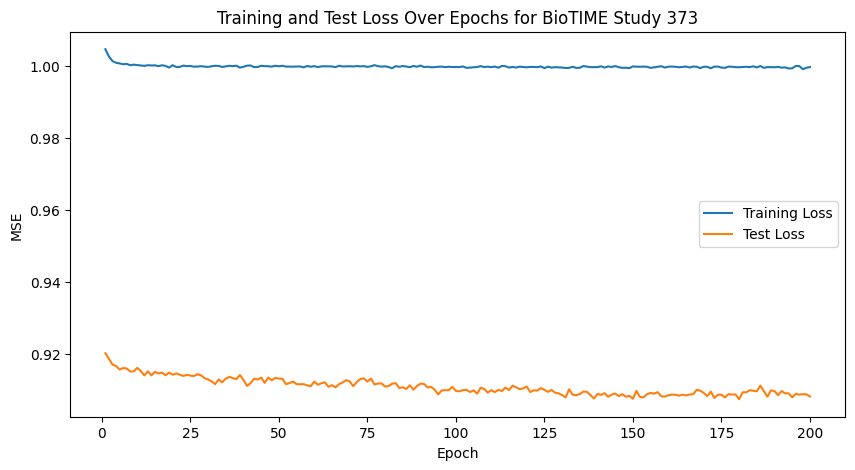

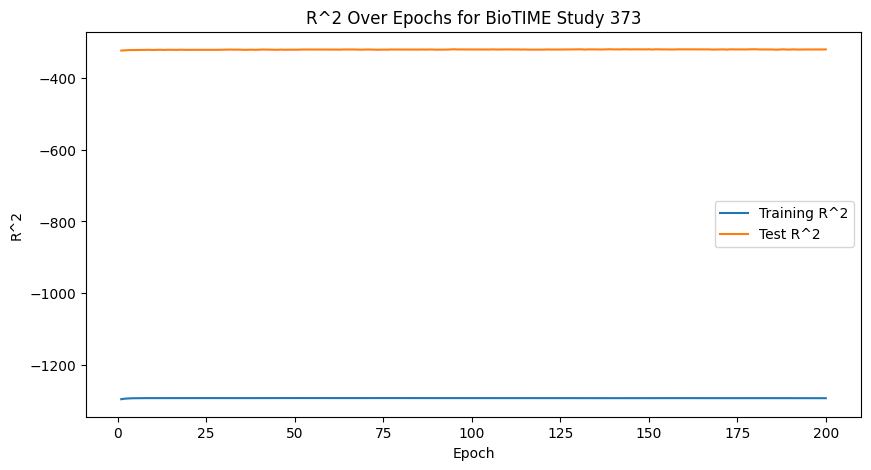

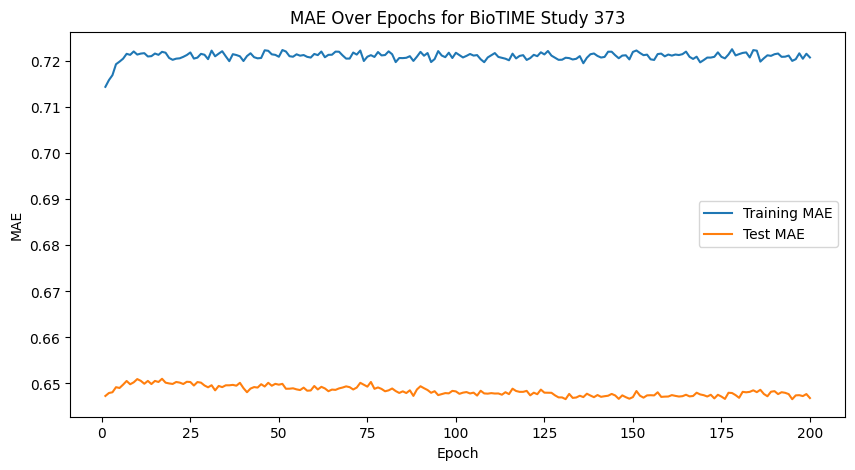

Final Test MSE: 0.9080920219421387
Final Test MAE: 0.6468355059623718
Final Test R2: -321.3242450113539


In [34]:
epochs = 200
train_losses = []
test_losses = []

train_r2 = []
test_r2 = []

train_mae = []
test_mae = []

for epoch in range(epochs):
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=32, verbose=0)
        
    # Access losses directly from history object
    train_mse = history.history['loss'][-1]
    test_mse = history.history['val_loss'][-1]
    train_mae_score = history.history['mean_absolute_error'][-1]
    test_mae_score = history.history['val_mean_absolute_error'][-1]

    y_train_pred = model.predict(x_train, verbose=0)
    y_test_pred = model.predict(x_test, verbose=0)
    train_r2_score = util.r_squared(y_train, y_train_pred)
    test_r2_score = util.r_squared(y_test, y_test_pred)
    
    train_losses.append(train_mse)
    test_losses.append(test_mse)
    train_mae.append(train_mae_score)
    test_mae.append(test_mae_score)
    train_r2.append(train_r2_score)
    test_r2.append(test_r2_score)

# Plotting training and testing loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(f'Training and Test Loss Over Epochs for {dataset_name}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_r2, label='Training R^2')
plt.plot(range(1, epochs+1), test_r2, label='Test R^2')
plt.title(f'R^2 Over Epochs for {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_mae, label='Training MAE')
plt.plot(range(1, epochs+1), test_mae, label='Test MAE')
plt.title(f'MAE Over Epochs for {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Final evaluation
final_mse_test = test_losses[-1]
final_mae_test = test_mae[-1]
final_r2_test = test_r2[-1]
print(f'Final Test MSE: {final_mse_test}')
print(f'Final Test MAE: {final_mae_test}')
print(f'Final Test R2: {final_r2_test}')

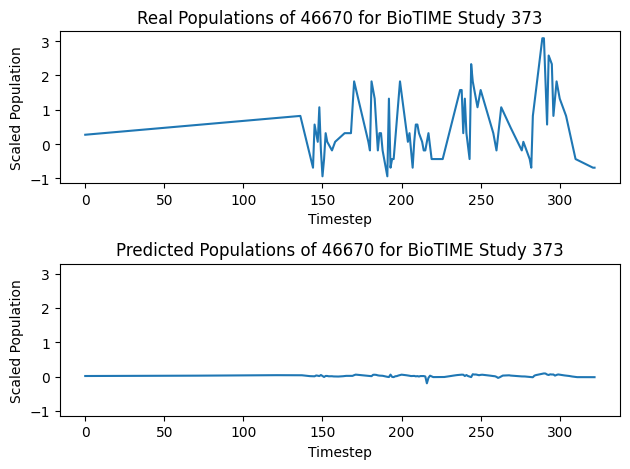

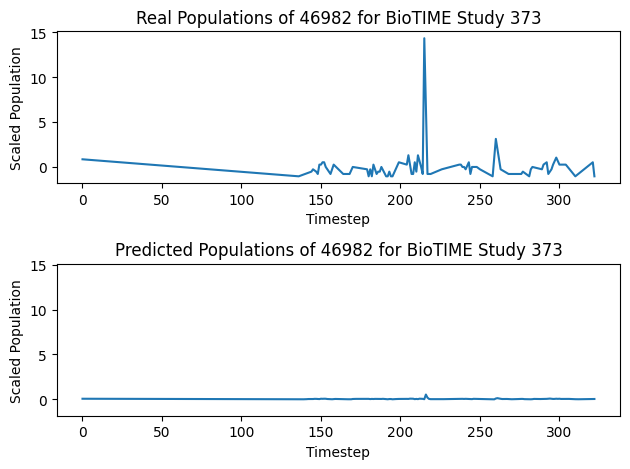

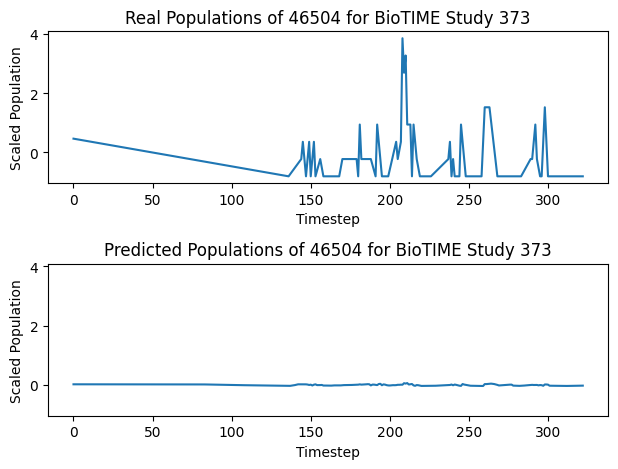

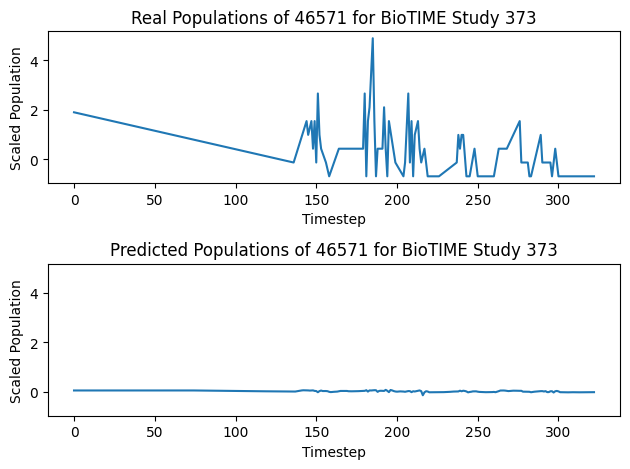

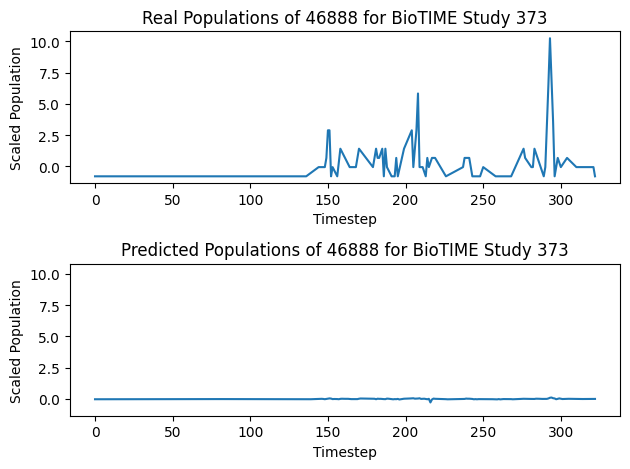

In [35]:
for expected, predicted, s  in zip(y_test.T, y_test_pred.T, species):
    _, (real, pred) = plt.subplots(2, sharey = True)
    pred.plot(range(len(predicted)), predicted.squeeze())
    pred.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    pred.set_xlabel('Timestep')
    pred.set_ylabel('Scaled Population')
    real.plot(range(len(predicted)), expected.squeeze())
    real.title.set_text(f'Real Populations of {s} for {dataset_name}')
    real.set_xlabel('Timestep')
    real.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()



In [36]:
df = pd.read_csv('Datasets/study_213/top_5_213_time.csv', usecols=['7058', '8572', '39601', '8901', '7730'])
"""
7058 ['Merluccius bilinearis']  Silver hake             -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
8572 ['Squalus acanthias']      Spiny dogfish           -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
39601 ['Doryteuthis pealeii']   Longfin inshore squid   -> Silver hake, Longfin inshore squid
8901 ['Urophycis chuss']        Red hake                -> Silver hake, Longfin inshore squid, Red hake, American butterfish
7730 ['Peprilus triacanthus']   American butterfish     -> Longfin inshore squid
"""

for col in ['7058', '8572', '39601', '8901', '7730']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)

dataset_name = 'BioTIME Study 213'

# Define features (x) and targets (y)
x = df[['7058_lag1', '8572_lag1', '39601_lag1', '8901_lag1', '7730_lag1']].values  # previous time step's data as input
y = df[['7058', '8572', '39601', '8901', '7730']].values  
species = ['7058', '8572', '39601', '8901', '7730']
print(df)

              7058        8572       39601        8901       7730  \
1      1488.923077  409.384615   18.923077  161.423077   1.961538   
2      1446.846154  396.769231   18.846154  158.846154   1.923077   
3      1404.769231  384.153846   18.769231  156.269231   1.884615   
4      1362.692308  371.538462   18.692308  153.692308   1.846154   
5      1320.615385  358.923077   18.615385  151.115385   1.807692   
...            ...         ...         ...         ...        ...   
16427   732.000000  468.000000   32.000000  186.000000   1.000000   
16428   568.500000  351.750000  141.750000  139.750000   4.250000   
16429   405.000000  235.500000  251.500000   93.500000   7.500000   
16430   241.500000  119.250000  361.250000   47.250000  10.750000   
16431    78.000000    3.000000  471.000000    1.000000  14.000000   

         7058_lag1   8572_lag1  39601_lag1   8901_lag1  7730_lag1  
1      1531.000000  422.000000   19.000000  164.000000   2.000000  
2      1488.923077  409.384615   18

In [37]:
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [38]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

y_train = y_train.reshape((y_train.shape[0], 1, y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], 1, y_test.shape[1]))

In [39]:
model = Sequential([
    LSTM(10, activation='relu', input_shape=(1, x_train.shape[2])),
    Dense(5)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/Users/ethankaji/Development/ML-on-Graphs-Project/311venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


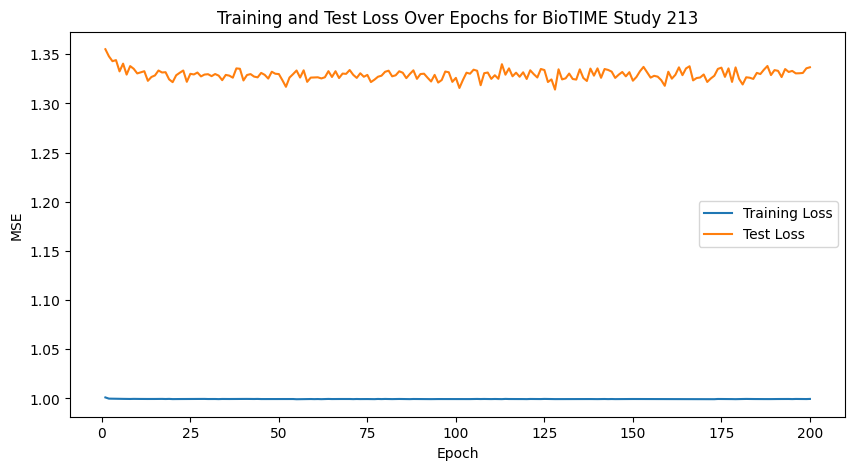

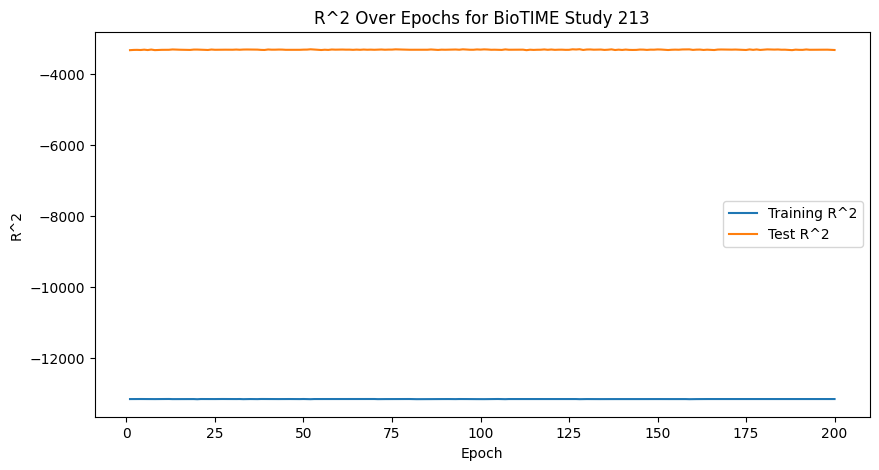

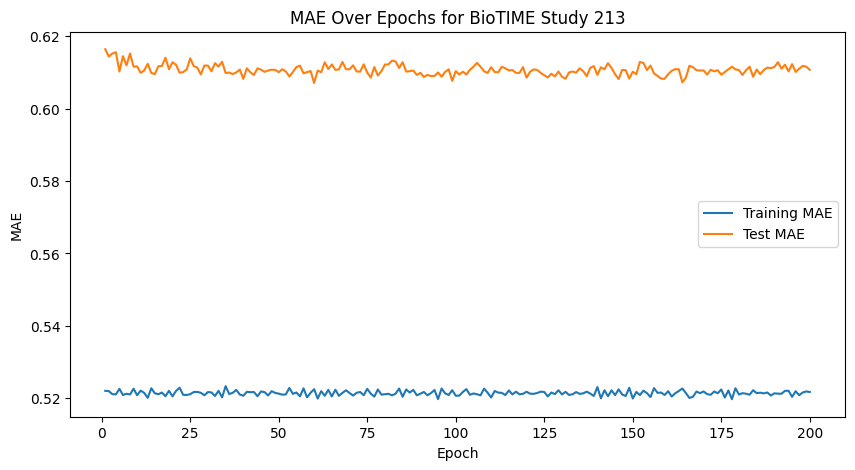

Final Test MSE: 1.336780071258545
Final Test MAE: 0.6106946468353271
Final Test R2: -3317.1729343977586


In [40]:
epochs = 200
train_losses = []
test_losses = []

train_r2 = []
test_r2 = []

train_mae = []
test_mae = []

for epoch in range(epochs):
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=32, verbose=0)
        
    # Access losses directly from history object
    train_mse = history.history['loss'][-1]
    test_mse = history.history['val_loss'][-1]
    train_mae_score = history.history['mean_absolute_error'][-1]
    test_mae_score = history.history['val_mean_absolute_error'][-1]

    y_train_pred = model.predict(x_train, verbose=0)
    y_test_pred = model.predict(x_test, verbose=0)
    train_r2_score = util.r_squared(y_train, y_train_pred)
    test_r2_score = util.r_squared(y_test, y_test_pred)
    
    train_losses.append(train_mse)
    test_losses.append(test_mse)
    train_mae.append(train_mae_score)
    test_mae.append(test_mae_score)
    train_r2.append(train_r2_score)
    test_r2.append(test_r2_score)

# Plotting training and testing loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(f'Training and Test Loss Over Epochs for {dataset_name}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_r2, label='Training R^2')
plt.plot(range(1, epochs+1), test_r2, label='Test R^2')
plt.title(f'R^2 Over Epochs for {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_mae, label='Training MAE')
plt.plot(range(1, epochs+1), test_mae, label='Test MAE')
plt.title(f'MAE Over Epochs for {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Final evaluation
final_mse_test = test_losses[-1]
final_mae_test = test_mae[-1]
final_r2_test = test_r2[-1]
print(f'Final Test MSE: {final_mse_test}')
print(f'Final Test MAE: {final_mae_test}')
print(f'Final Test R2: {final_r2_test}')

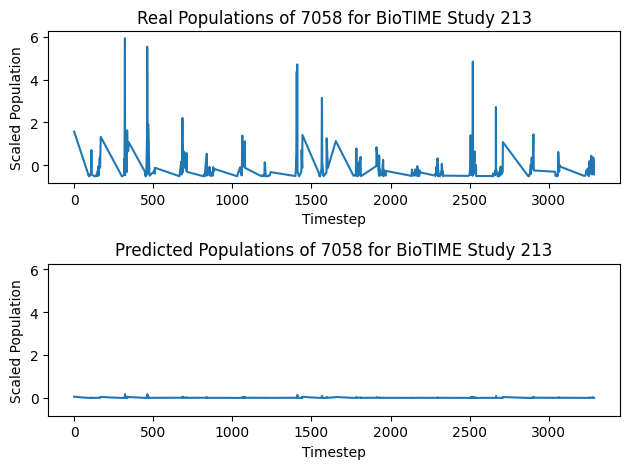

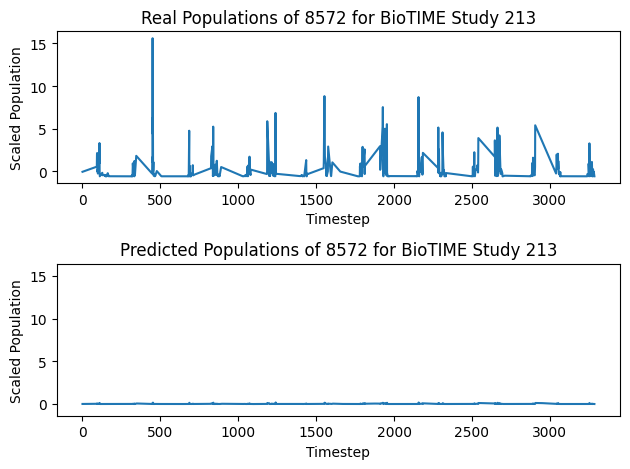

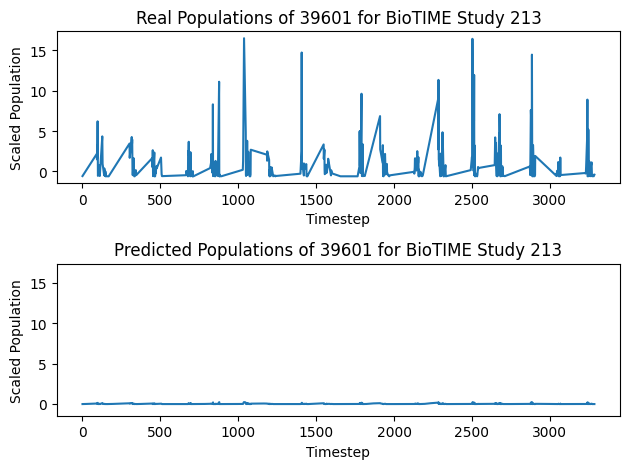

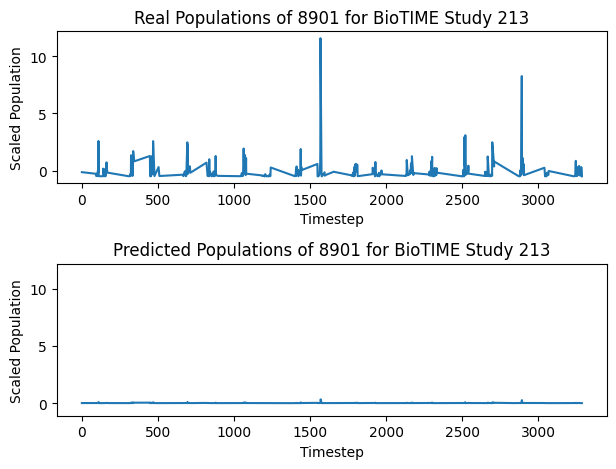

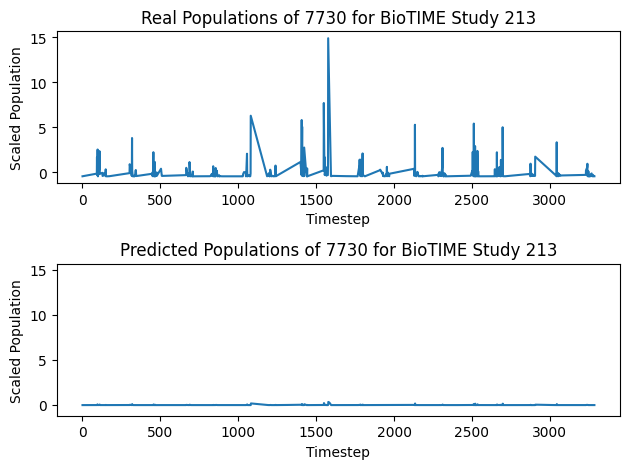

In [41]:
for expected, predicted, s  in zip(y_test.T, y_test_pred.T, species):
    _, (real, pred) = plt.subplots(2, sharey = True)
    pred.plot(range(len(predicted)), predicted.squeeze())
    pred.title.set_text(f'Predicted Populations of {s} for {dataset_name}')
    pred.set_xlabel('Timestep')
    pred.set_ylabel('Scaled Population')
    real.plot(range(len(predicted)), expected.squeeze())
    real.title.set_text(f'Real Populations of {s} for {dataset_name}')
    real.set_xlabel('Timestep')
    real.set_ylabel('Scaled Population')
    plt.tight_layout()
    plt.show()

